##

# CS680 Project: Finding the correlation between pull request features and contibuter's Gender

Importing the necessary libraries:

In [43]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import seaborn as sns
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from imblearn.over_sampling import RandomOverSampler, SMOTE


## Read the dataset

In [3]:
#with Pandas
df = pd.read_csv("/Users/amirrshams/Library/CloudStorage/OneDrive-UniversityofWaterloo/Courses/Term_2/CS680/Projects/Dataset/new_pullreq.csv")

In [3]:
df.head()

,id,project_id,ownername,reponame,merged_or_not,lifetime_minutes,mergetime_minutes,num_commits,src_churn,test_churn,files_added,files_deleted,files_modified,files_changed,src_files,doc_files,other_files,num_commit_comments,num_issue_comments,num_comments,num_participants,sloc,team_size,perc_external_contribs,commits_on_files_touched,test_lines_per_kloc,test_cases_per_kloc,asserts_per_kloc,watchers,prev_pullreqs,requester_succ_rate,followers,churn_addition,churn_deletion,pr_comment_num,comment_num,perc_neg_emotion,perc_pos_emotion,perc_neu_emotion,part_num_issue,part_num_commit,part_num_pr,part_num_code,comment_conflict,hash_tag,at_tag,test_inclusion,description_length,bug_fix,ci_exists,ci_latency,ci_build_num,ci_test_passed,ci_failed_perc,ci_first_build_status,ci_last_build_status,language,fork_num,project_age,open_issue_num,pr_succ_rate,open_pr_num,first_response_time,pushed_delta,acc_commit_num,first_pr,account_creation_days,core_member,contrib_gender,contrib_country,contrib_affiliation,contrib_open,contrib_cons,contrib_extra,contrib_agree,contrib_neur,perc_contrib_neg_emo,perc_contrib_pos_emo,perc_contrib_neu_emo,contrib_first_emo,prior_review_num,inte_country,inte_affiliation,inte_open,inte_cons,inte_extra,inte_agree,inte_neur,perc_inte_neg_emo,perc_inte_pos_emo,perc_inte_neu_emo,inte_first_emo,contrib_follow_integrator,prior_interaction,social_strength,same_country,same_affiliation,open_diff,cons_diff,extra_diff,agree_diff,neur_diff,has_comments,has_participants,has_exchange,contrib_comment,inte_comment,reviewer_comment,other_comment,num_comments_con,num_code_comments,num_code_comments_con,integrator_availability,friday_effect,contrib_rate_author,reopen_or_not,first_close_minutes,reopen_num
0,1,13708387,stylelint,stylelint,1,237,237.0,1,0,0,0,0,1,1,0,0,1,0,1,1,1,14668.0,15,0.089869,79,745.04600,0.0000,0.000000,2070,14,1.000000,118,0,0,0,1,0.0,0.0,1.0,1,0,0,0,0,1,0,0,4926,NaN,1.0,274.0,1.0,1.0,0.0,success,success,JavaScript,140,21,52,0.978469,25,237.0,196583.0,28,0,353,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,14,NaN,NaN,0.805841,0.629980,0.468658,0.658221,0.541352,0.0,0.0,1.0,neutral,0,28,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,0,0,1,1,0,0,0,0,30.0,1,0.007948,0,237,0
1,2,100297899,Joaogarciadelima,checklistos,0,1410,NaN,1,0,0,0,0,1,1,0,0,0,0,2,2,1,474.0,2,0.014019,38,147.48200,16.1870,21.582700,1,299,1.000000,38,0,0,0,2,0.0,0.0,0.0,1,0,0,0,0,0,0,0,1312,NaN,1.0,79.0,1.0,0.0,1.0,failure,failure,Python,1,6,1,1.000000,7,NaN,9.0,432,0,1092,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0,300,0.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,1,0,2,0,0,597.0,0,0.830769,0,1410,0
2,3,93139005,binary-com,SmartCharts,1,4,4.0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,34921.0,5,0.256849,175,4.64599,0.0000,0.114012,5,81,0.987654,33,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,4,NaN,1.0,88.0,1.0,1.0,0.0,success,success,JavaScript,11,6,0,0.996324,10,NaN,5743.0,652,0,1884,1,male,malaysia,NaN,0.796278,0.656912,0.485889,0.655315,0.609593,0.0,0.0,0.0,NaN,94,malaysia,NaN,0.796278,0.656912,0.485889,0.655315,0.609593,0.0,0.0,0.0,NaN,0,505,0.428571,1.0,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,2.0,0,0.314368,0,4,0
3,4,15059440,letsencrypt,boulder,1,52,52.0,1,9,104,0,0,2,2,2,0,0,0,0,0,0,143159.0,5,0.014706,24,120.71000,0.0000,10.109800,2194,293,0.989761,222,110,3,0,0,0.0,0.0,0.0,0,0,0,0,0,0,1,1,94,NaN,1.0,489.0,1.0,1.0,0.0,success,success,Go,269,37,212,0.986523,29,NaN,978.0,1050,0,3489,1,male,canada,NaN,0.814346,0.633765,0.471257,0.666831,0.485847,0.0,0.0,0.0,NaN,679,NaN,NaN,0.818143,0.630804,0.466899,0.650931,0.496465,0.0,0.0,0.0,NaN,1,460,0.138889,NaN,NaN,0.003796,0.002961,0.004358,0.015900,0.010618,0,0,0,0,0,0,0,0,0,0,1.0,0,0.117332,0,52,0
4,5,29684214,PyCQA,astroid,1,2414,2414.0,1,33,27,0,0,2,2,2,0,0,0,1,1,1,6247.0,2,0.173077,7,554.16800,28.6183,84.142200,131,3,1.000000,1,60,0,0,1,0.0,1.0,0.0,1,0,0,0,0,0,0,1,49,NaN,1.0,261.0,1.0,1.0,0.0,success,success,Python,64,25,93,0.978495,9,241

In [4]:
df.shape

(3347937, 118)

The dataset has 2,653,541 pull request with 118 columns

Here I dropped the rows where gender was null, I don't need them for the model.

In [5]:
#dropping the rows where a column has a null value
df = df.dropna(subset=['contrib_gender'])

In [6]:
df.count()

id                     2653541
project_id             2653541
ownername              2653541
reponame               2653541
merged_or_not          2653541
                        ...   
friday_effect          2653541
contrib_rate_author    2653541
reopen_or_not          2653541
first_close_minutes    2653541
reopen_num             2653541
Length: 118, dtype: int64

In [7]:
#drop the columns that are not needed
df = df.drop(["id", "project_id", "ownername", "reponame"], axis=1)

In [8]:
#move column contrib_gender to the beginning of the dataframe
col = df.pop("contrib_gender")
df.insert(0, "contrib_gender", col)

In [9]:
df.head()

,contrib_gender,merged_or_not,lifetime_minutes,mergetime_minutes,num_commits,src_churn,test_churn,files_added,files_deleted,files_modified,files_changed,src_files,doc_files,other_files,num_commit_comments,num_issue_comments,num_comments,num_participants,sloc,team_size,perc_external_contribs,commits_on_files_touched,test_lines_per_kloc,test_cases_per_kloc,asserts_per_kloc,watchers,prev_pullreqs,requester_succ_rate,followers,churn_addition,churn_deletion,pr_comment_num,comment_num,perc_neg_emotion,perc_pos_emotion,perc_neu_emotion,part_num_issue,part_num_commit,part_num_pr,part_num_code,comment_conflict,hash_tag,at_tag,test_inclusion,description_length,bug_fix,ci_exists,ci_latency,ci_build_num,ci_test_passed,ci_failed_perc,ci_first_build_status,ci_last_build_status,language,fork_num,project_age,open_issue_num,pr_succ_rate,open_pr_num,first_response_time,pushed_delta,acc_commit_num,first_pr,account_creation_days,core_member,contrib_country,contrib_affiliation,contrib_open,contrib_cons,contrib_extra,contrib_agree,contrib_neur,perc_contrib_neg_emo,perc_contrib_pos_emo,perc_contrib_neu_emo,contrib_first_emo,prior_review_num,inte_country,inte_affiliation,inte_open,inte_cons,inte_extra,inte_agree,inte_neur,perc_inte_neg_emo,perc_inte_pos_emo,perc_inte_neu_emo,inte_first_emo,contrib_follow_integrator,prior_interaction,social_strength,same_country,same_affiliation,open_diff,cons_diff,extra_diff,agree_diff,neur_diff,has_comments,has_participants,has_exchange,contrib_comment,inte_comment,reviewer_comment,other_comment,num_comments_con,num_code_comments,num_code_comments_con,integrator_availability,friday_effect,contrib_rate_author,reopen_or_not,first_close_minutes,reopen_num
2,male,1,4,4.0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,34921.0,5,0.256849,175,4.64599,0.0000,0.114012,5,81,0.987654,33,0,0,0,0,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,4,NaN,1.0,88.0,1.0,1.0,0.0,success,success,JavaScript,11,6,0,0.996324,10,NaN,5743.0,652,0,1884,1,malaysia,NaN,0.796278,0.656912,0.485889,0.655315,0.609593,0.0,0.0,0.0,NaN,94,malaysia,NaN,0.796278,0.656912,0.485889,0.655315,0.609593,0.0,0.0,0.0,NaN,0,505,0.428571,1.0,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,2.0,0,0.314368,0,4,0
3,male,1,52,52.0,1,9,104,0,0,2,2,2,0,0,0,0,0,0,143159.0,5,0.014706,24,120.71000,0.0000,10.109800,2194,293,0.989761,222,110,3,0,0,0.0,0.000000,0.000000,0,0,0,0,0,0,1,1,94,NaN,1.0,489.0,1.0,1.0,0.0,success,success,Go,269,37,212,0.986523,29,NaN,978.0,1050,0,3489,1,canada,NaN,0.814346,0.633765,0.471257,0.666831,0.485847,0.0,0.0,0.0,NaN,679,NaN,NaN,0.818143,0.630804,0.466899,0.650931,0.496465,0.0,0.0,0.0,NaN,1,460,0.138889,NaN,NaN,0.003796,0.002961,0.004358,0.015900,0.010618,0,0,0,0,0,0,0,0,0,0,1.0,0,0.117332,0,52,0
5,male,1,91,91.0,1,26,0,0,0,1,1,1,0,0,0,0,0,0,12180.0,4,0.000000,13,211.34400,0.2590,0.064750,0,70,1.000000,10,11,15,0,0,0.0,0.000000,0.000000,0,0,0,0,0,0,0,0,13,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,JavaScript,0,13,0,1.000000,1,NaN,340172.0,452,0,2617,1,NaN,NaN,0.753492,0.592123,0.534004,0.718830,0.666233,0.0,0.0,0.0,NaN,84,NaN,NaN,0.752607,0.592129,0.534000,0.718828,0.661787,0.0,0.0,0.0,NaN,0,203,0.400000,NaN,NaN,0.000884,0.000006,0.000004,0.000002,0.004445,0,0,0,0,0,0,0,0,0,0,161.0,0,0.456105,0,91,0
6,male,1,52694,52694.0,3,127,0,0,0,3,3,3,0,0,0,3,3,3,2359.0,6,0.333333,0,517.19200,22.9226,119.730000,14,0,0.000000,2,119,8,0,3,0.0,0.666667,0.333333,3,0,0,0,0,1,0,0,80,NaN,1.0,218.0,1.0,1.0,0.0,success,success,Python,48,51,53,0.845238,9,10767.0,1267110.0,1,1,1306,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,neutral,39,NaN,NaN,0.827492,0.623520,0.466355,0.650985,0.490121,0.0,1.0,0.0,positive,0,1,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,1,0,1,0,0,1354.0,0,0.003636,0,52694,0
7,female,1,1221,1221.0,3,6634,1480,90,2,9,101,50,47,4,0,0,0,0,19657.0,1,0.039216,11,0.00000,0.0000,0.000000,48,3,1.000000,138,7723,391,0,0,0.0,0.000000,0.000000,0,0,0,0,0,0,1,1,328,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,JavaScript,18,15,7,0.967742,2,NaN,1052200.0,49,0,1294,0,NaN,sas,0.821807,0.616649,0.4

In [11]:
data = df.copy()

In [10]:
gender_counts = df["contrib_gender"].value_counts()

# Print the frequency of each gender
print("Male contributors: ", gender_counts[0])
print(f"Male precentage {gender_counts[0]/len(df)*100:.2f}%")
print("Female contributors: ", gender_counts[1])
print(f"Female precentage {gender_counts[1]/len(df)*100:.2f}%")


Male contributors:  2392463
Male precentage 90.16%
Female contributors:  261078
Female precentage 9.84%


In [12]:
cat_cols = data.select_dtypes(include=['object']).columns.to_list()
print(cat_cols)
label_encoder = LabelEncoder()
# for this lable encoder, i want male to be 0 and female be 1
for col in cat_cols:
    data[col] = label_encoder.fit_transform(data[col]).astype('int64')
data['contrib_gender'] = 1 - data['contrib_gender']

['contrib_gender', 'ci_first_build_status', 'ci_last_build_status', 'language', 'contrib_country', 'contrib_affiliation', 'contrib_first_emo', 'inte_country', 'inte_affiliation', 'inte_first_emo']


In [14]:
data.head(20)

,contrib_gender,merged_or_not,lifetime_minutes,mergetime_minutes,num_commits,src_churn,test_churn,files_added,files_deleted,files_modified,files_changed,src_files,doc_files,other_files,num_commit_comments,num_issue_comments,num_comments,num_participants,sloc,team_size,perc_external_contribs,commits_on_files_touched,test_lines_per_kloc,test_cases_per_kloc,asserts_per_kloc,watchers,prev_pullreqs,requester_succ_rate,followers,churn_addition,churn_deletion,pr_comment_num,comment_num,perc_neg_emotion,perc_pos_emotion,perc_neu_emotion,part_num_issue,part_num_commit,part_num_pr,part_num_code,comment_conflict,hash_tag,at_tag,test_inclusion,description_length,bug_fix,ci_exists,ci_latency,ci_build_num,ci_test_passed,ci_failed_perc,ci_first_build_status,ci_last_build_status,language,fork_num,project_age,open_issue_num,pr_succ_rate,open_pr_num,first_response_time,pushed_delta,acc_commit_num,first_pr,account_creation_days,core_member,contrib_country,contrib_affiliation,contrib_open,contrib_cons,contrib_extra,contrib_agree,contrib_neur,perc_contrib_neg_emo,perc_contrib_pos_emo,perc_contrib_neu_emo,contrib_first_emo,prior_review_num,inte_country,inte_affiliation,inte_open,inte_cons,inte_extra,inte_agree,inte_neur,perc_inte_neg_emo,perc_inte_pos_emo,perc_inte_neu_emo,inte_first_emo,contrib_follow_integrator,prior_interaction,social_strength,same_country,same_affiliation,open_diff,cons_diff,extra_diff,agree_diff,neur_diff,has_comments,has_participants,has_exchange,contrib_comment,inte_comment,reviewer_comment,other_comment,num_comments_con,num_code_comments,num_code_comments_con,integrator_availability,friday_effect,contrib_rate_author,reopen_or_not,first_close_minutes,reopen_num
2,0,1,4,4.0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,34921.0,5,0.256849,175,4.64599,0.000000,0.114012,5,81,0.987654,33,0,0,0,0,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,4,NaN,1.0,88.0,1.0,1.0,0.000000,1,1,2,11,6,0,0.996324,10,NaN,5743.0,652,0,1884,1,95,1185,0.796278,0.656912,0.485889,0.655315,0.609593,0.000000,0.0,0.000000,3,94,81,1087,0.796278,0.656912,0.485889,0.655315,0.609593,0.0,0.000000,0.000000,3,0,505,0.428571,1.0,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,2.0,0,0.314368,0,4,0
3,0,1,52,52.0,1,9,104,0,0,2,2,2,0,0,0,0,0,0,143159.0,5,0.014706,24,120.71000,0.000000,10.109800,2194,293,0.989761,222,110,3,0,0,0.000000,0.000000,0.000000,0,0,0,0,0,0,1,1,94,NaN,1.0,489.0,1.0,1.0,0.000000,1,1,0,269,37,212,0.986523,29,NaN,978.0,1050,0,3489,1,28,1185,0.814346,0.633765,0.471257,0.666831,0.485847,0.000000,0.0,0.000000,3,679,145,1087,0.818143,0.630804,0.466899,0.650931,0.496465,0.0,0.000000,0.000000,3,1,460,0.138889,NaN,NaN,0.003796,0.002961,0.004358,0.015900,0.010618,0,0,0,0,0,0,0,0,0,0,1.0,0,0.117332,0,52,0
5,0,1,91,91.0,1,26,0,0,0,1,1,1,0,0,0,0,0,0,12180.0,4,0.000000,13,211.34400,0.259000,0.064750,0,70,1.000000,10,11,15,0,0,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,13,NaN,1.0,NaN,NaN,NaN,NaN,2,2,2,0,13,0,1.000000,1,NaN,340172.0,452,0,2617,1,175,1185,0.753492,0.592123,0.534004,0.718830,0.666233,0.000000,0.0,0.000000,3,84,145,1087,0.752607,0.592129,0.534000,0.718828,0.661787,0.0,0.000000,0.000000,3,0,203,0.400000,NaN,NaN,0.000884,0.000006,0.000004,0.000002,0.004445,0,0,0,0,0,0,0,0,0,0,161.0,0,0.456105,0,91,0
6,0,1,52694,52694.0,3,127,0,0,0,3,3,3,0,0,0,3,3,3,2359.0,6,0.333333,0,517.19200,22.922600,119.730000,14,0,0.000000,2,119,8,0,3,0.000000,0.666667,0.333333,3,0,0,0,0,1,0,0,80,NaN,1.0,218.0,1.0,1.0,0.000000,1,1,3,48,51,53,0.845238,9,10767.0,1267110.0,1,1,1306,0,175,1185,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,1.000000,1,39,145,1087,0.827492,0.623520,0.466355,0.650985,0.490121,0.0,1.000000,0.000000,2,0,1,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,1,0,1,0,0,1354.0,0,0.003636,0,52694,0
7,1,1,1221,1221.0,3,6634,1480,90,2,9,101,50,47,4,0,0,0,0,19657.0,1,0.039216,11,0.00000,0.000000,0.000000,48,3,1.000000,138,7723,391,0,0,0.000000,0.000000,0.000000,0,0,0,0,0,0,1,1,328,NaN,0.0,NaN,NaN,NaN,NaN,2,2,2,18,15,7,0.967742,2,NaN,1052200.0,49,0,1294,0,175,802,0.821807,0.616649,

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2653541 entries, 2 to 3347936
Columns: 114 entries, contrib_gender to reopen_num
dtypes: float64(45), int64(69)
memory usage: 2.3 GB


## Finding the correlation and preparing the data
using Pearson Correlation

In [16]:
corr = data.corr()
corr.head()

,contrib_gender,merged_or_not,lifetime_minutes,mergetime_minutes,num_commits,src_churn,test_churn,files_added,files_deleted,files_modified,files_changed,src_files,doc_files,other_files,num_commit_comments,num_issue_comments,num_comments,num_participants,sloc,team_size,perc_external_contribs,commits_on_files_touched,test_lines_per_kloc,test_cases_per_kloc,asserts_per_kloc,watchers,prev_pullreqs,requester_succ_rate,followers,churn_addition,churn_deletion,pr_comment_num,comment_num,perc_neg_emotion,perc_pos_emotion,perc_neu_emotion,part_num_issue,part_num_commit,part_num_pr,part_num_code,comment_conflict,hash_tag,at_tag,test_inclusion,description_length,bug_fix,ci_exists,ci_latency,ci_build_num,ci_test_passed,ci_failed_perc,ci_first_build_status,ci_last_build_status,language,fork_num,project_age,open_issue_num,pr_succ_rate,open_pr_num,first_response_time,pushed_delta,acc_commit_num,first_pr,account_creation_days,core_member,contrib_country,contrib_affiliation,contrib_open,contrib_cons,contrib_extra,contrib_agree,contrib_neur,perc_contrib_neg_emo,perc_contrib_pos_emo,perc_contrib_neu_emo,contrib_first_emo,prior_review_num,inte_country,inte_affiliation,inte_open,inte_cons,inte_extra,inte_agree,inte_neur,perc_inte_neg_emo,perc_inte_pos_emo,perc_inte_neu_emo,inte_first_emo,contrib_follow_integrator,prior_interaction,social_strength,same_country,same_affiliation,open_diff,cons_diff,extra_diff,agree_diff,neur_diff,has_comments,has_participants,has_exchange,contrib_comment,inte_comment,reviewer_comment,other_comment,num_comments_con,num_code_comments,num_code_comments_con,integrator_availability,friday_effect,contrib_rate_author,reopen_or_not,first_close_minutes,reopen_num
contrib_gender,1.000000,0.005715,-0.010444,-0.008586,0.008371,-0.000639,-0.002418,0.001890,0.000851,0.002531,0.002655,-0.001566,0.004785,0.004877,-0.002810,-0.012966,-0.003255,-0.012892,0.008074,0.019142,0.012589,0.021871,-0.016099,-0.009208,-0.011752,0.001166,0.038656,0.013807,-0.016155,-0.000397,-0.000823,0.006164,-0.003255,-0.009455,-0.013552,-0.008146,-0.022163,-0.003892,0.008639,0.007650,-0.000950,0.003292,-0.004051,-0.008266,0.002730,0.037766,-0.016737,-0.002776,-0.002000,-0.001366,-0.000133,0.010193,0.010566,0.005135,0.009521,0.006587,0.014056,0.011838,0.020672,-0.005146,-0.010389,-0.001178,-0.012857,-0.118596,-0.011917,0.010883,0.000759,-0.017851,0.054232,0.016358,0.024116,0.011971,-0.008596,0.006589,-0.021349,0.020871,0.014643,0.003220,0.002695,-0.007602,0.018486,0.017617,0.000888,0.014495,-0.007125,-0.015039,-0.004657,0.010999,-0.008702,0.003623,-0.030930,0.008486,0.025591,0.001118,0.002577,0.002194,-0.005593,0.016096,-0.015617,-0.015647,-0.018148,-0.014914,-0.016426,-0.016506,-0.012096,-0.008920,0.005740,0.000345,0.015988,0.004436,-0.045221,0.001609,-0.010439,0.002612
merged_or_not,0.005715,1.000000,-0.197227,NaN,-0.027686,-0.004324,-0.012526,-0.019558,-0.007330,-0.020691,-0.023774,-0.024074,-0.008154,-0.009880,-0.019414,-0.093270,-0.055419,-0.145329,-0.022337,-0.098291,-0.080019,0.017567,-0.058426,-0.018361,-0.039633,-0.082201,0.064674,0.149746,0.004746,-0.009292,-0.001902,-0.004040,-0.055419,-0.059980,-0.037555,-0.135011,-0.174406,-0.030385,-0.001247,-0.007908,-0.021104,0.022056,-0.075160,-0.001918,-0.029392,0.010036,0.066095,-0.007547,0.014527,0.111131,-0.182242,-0.025457,-0.005567,-0.016766,-0.102601,-0.026848,-0.030720,0.121666,-0.096563,-0.080183,-0.003483,0.060757,-0.145294,0.108312,0.172580,0.019374,0.014516,0.016290,0.000095,0.000242,-0.020102,0.012415,-0.048334,-0.028504,-0.069587,0.085155,-0.006846,0.003542,0.008390,0.101818,0.015244,0.001597,-0.027309,0.006809,-0.014069,-0.014902,-0.042997,0.045604,0.034495,0.051319,0.124525,0.014890,0.009154,-0.106185,-0.005971,0.011105,-0.004632,-0.006935,-0.168571,-0.168579,-0.112670,-0.131820,-0.177351,-0.167588,-0.024887,-0.046999,-0.006336,0.001420,0.026443,0.002345,0.167458,-0.043743,-0.195523,-0.032706
lifetime_minutes,-0.010444,-0.197227,1.000000,0.991260,0.047485,0.004129,0.013837,0.015266,0.004490,0.0

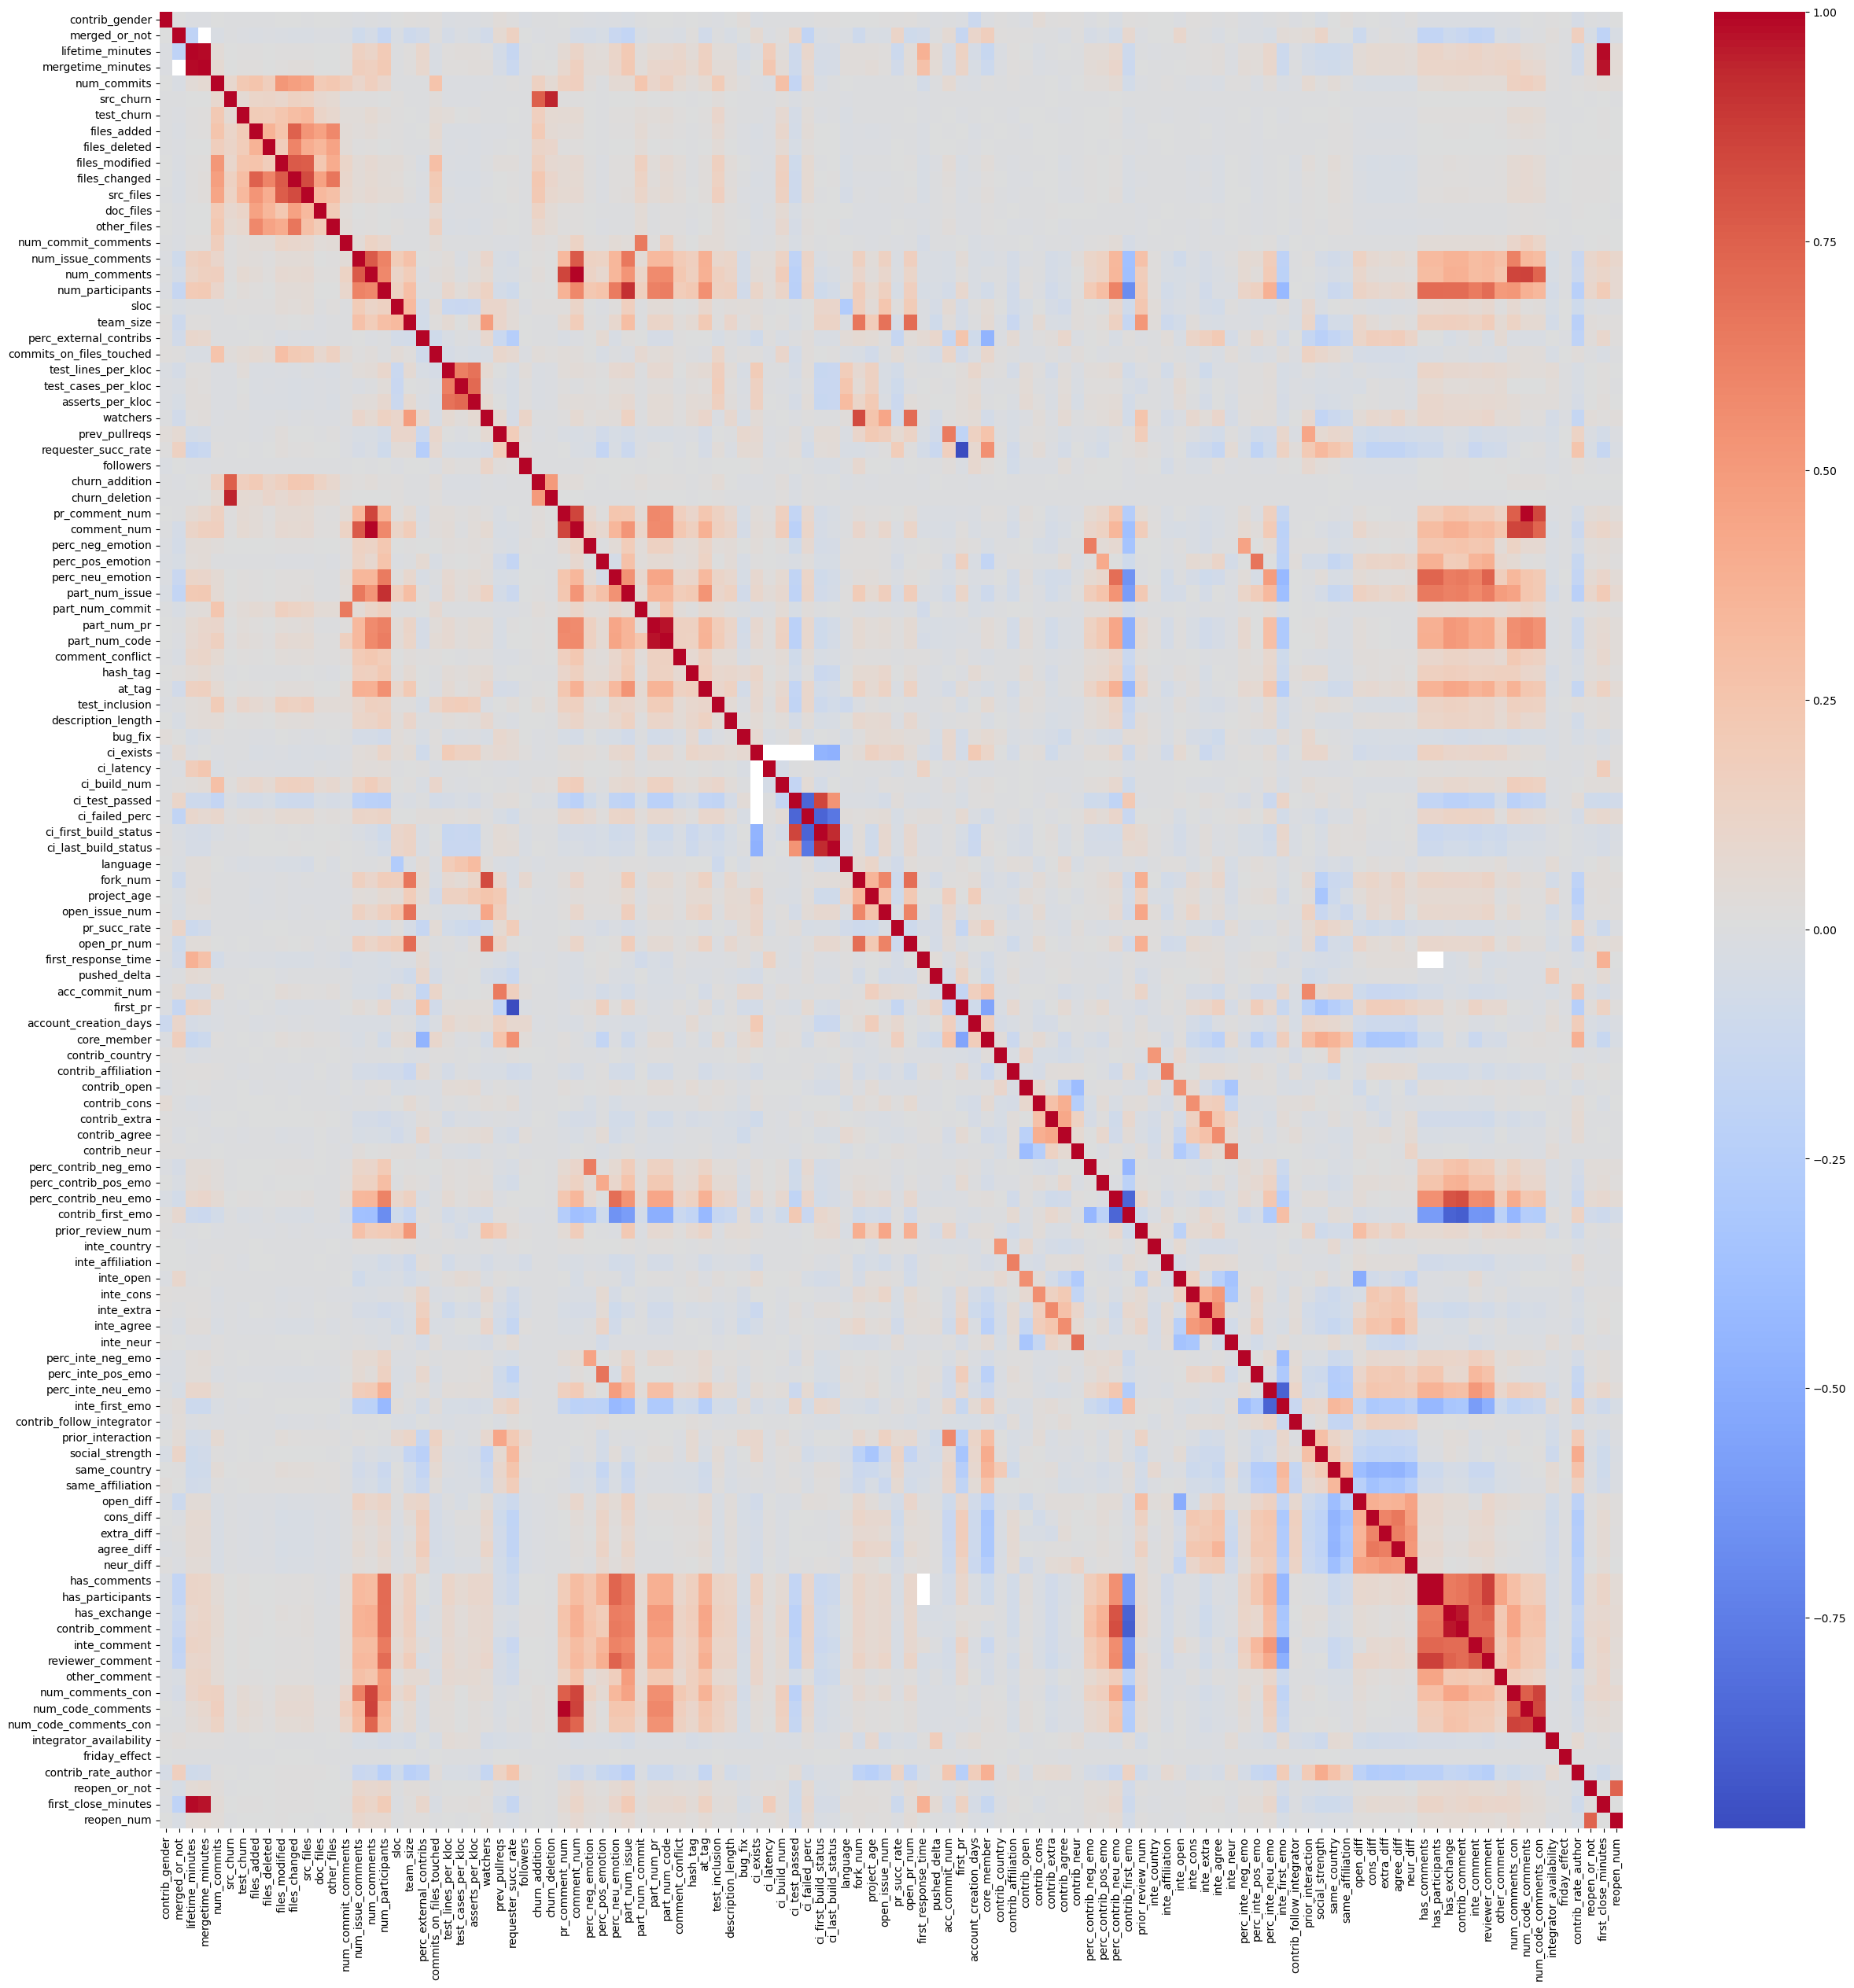

In [17]:
#scatter plot of heatmap
plt.figure(figsize=(30,30))
sns.heatmap(corr, cmap='coolwarm')
plt.show()


Removing one of two features with absolute correlation of higher than 0.75

In [18]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.75 or corr.iloc[i,j] < -0.75:
            if columns[j]:
                columns[j] = False
selected_columns = data.columns[columns]

In [19]:
selected_columns.shape

(89,)

In [20]:
data_new = data[selected_columns]

In [21]:
data_new.shape

(2653541, 89)

The new dataset with removed correlated features has 89 feature

Next, I am going to drop the features that are outside the control of the contributer. this has been done to make the dataset smaller and only take into account the features that logically has an effect on the gender, I am not going to drop the features that are boarderline or I am not sure of. these are mostly project characteristics and integrator characteristics

In [22]:
data_contributer = data_new.drop(["merged_or_not","sloc", "team_size", "perc_external_contribs", "test_lines_per_kloc", "test_cases_per_kloc", "asserts_per_kloc", "watchers", "perc_neg_emotion", "perc_pos_emotion", "perc_neu_emotion", "part_num_commit", "part_num_pr", "comment_conflict", "hash_tag", "at_tag", "project_age", "open_issue_num", "pr_succ_rate", "open_pr_num", "first_response_time", "pushed_delta", "inte_country", "inte_affiliation", "inte_open", "inte_cons", "inte_extra", "inte_agree", "inte_neur", "perc_inte_neg_emo", "perc_inte_pos_emo", "perc_inte_neu_emo", "has_comments", "inte_comment", "other_comment", "integrator_availability", "friday_effect", "contrib_rate_author", "reopen_or_not", "reopen_num", "open_diff", "cons_diff", "extra_diff", "agree_diff", "neur_diff"], axis=1)

In [23]:
#Also removing features that not based on the contributions of the contributor
data_contributer = data_contributer.drop(["contrib_cons","contrib_extra", "contrib_agree", "contrib_neur", "contrib_open"], axis=1)

We are going to look at the percentage of missing values in each feature to decide what to do with each feature in regards to missing values

In [24]:
data_ratio_missing = data_contributer.isnull().mean() * 100
data_ratio_missing

contrib_gender                0.000000
lifetime_minutes              0.000000
num_commits                   0.000000
src_churn                     0.000000
test_churn                    0.000000
files_added                   0.000000
files_deleted                 0.000000
files_modified                0.000000
doc_files                     0.000000
other_files                   0.000000
num_commit_comments           0.000000
num_issue_comments            0.000000
num_participants              0.000000
commits_on_files_touched      0.000000
prev_pullreqs                 0.000000
requester_succ_rate           0.000000
followers                     0.000000
test_inclusion                0.000000
description_length            0.000000
bug_fix                      99.236492
ci_exists                     0.083021
ci_latency                   53.591748
ci_build_num                 53.591748
ci_test_passed               53.591748
language                      0.000000
acc_commit_num           

Some examples of the number of missing values in some of the features.

In [35]:
data_contributer[data_contributer["ci_exists"].isnull()].count()

contrib_gender             2203
merged_or_not              2203
lifetime_minutes           2203
num_commits                2203
src_churn                  2203
                           ... 
integrator_availability    2073
friday_effect              2203
contrib_rate_author        2203
reopen_or_not              2203
reopen_num                 2203
Length: 84, dtype: int64

In [24]:
data_contributer[data_contributer["perc_contrib_neg_emo"].isnull()].count()

contrib_gender               9220
lifetime_minutes             9220
num_commits                  9220
src_churn                    9220
test_churn                   9220
files_added                  9220
files_deleted                9220
files_modified               9220
doc_files                    9220
other_files                  9220
num_commit_comments          9220
num_issue_comments           9220
num_participants             9220
commits_on_files_touched     9220
prev_pullreqs                9220
requester_succ_rate          9220
followers                    9220
test_inclusion               9220
description_length           9220
bug_fix                        56
ci_exists                    9218
ci_latency                   4295
ci_build_num                 4295
ci_test_passed               4295
language                     9220
acc_commit_num               9220
account_creation_days        9220
core_member                  9220
contrib_country              9220
contrib_affili

In [25]:
data_contributer[data_contributer["social_strength"].isnull()].count()

contrib_gender               200
lifetime_minutes             200
num_commits                  200
src_churn                    200
test_churn                   200
files_added                  200
files_deleted                200
files_modified               200
doc_files                    200
other_files                  200
num_commit_comments          200
num_issue_comments           200
num_participants             200
commits_on_files_touched     200
prev_pullreqs                200
requester_succ_rate          200
followers                    200
test_inclusion               200
description_length           200
bug_fix                        5
ci_exists                    200
ci_latency                    91
ci_build_num                  91
ci_test_passed                91
language                     200
acc_commit_num               200
account_creation_days        200
core_member                  200
contrib_country              200
contrib_affiliation          200
contrib_op

As there are a lot of missing values in the features bug_fix, same_country, same_affiliation, respectively 99.2, 62.8 and 79.1. I will drop these as well

In [25]:
data_contributer = data_contributer.drop(["bug_fix", "same_country", "same_affiliation"], axis=1)

Then i will look at the distribution of the features to decide what to do with missing values

In [26]:
data_contributer.head()

,contrib_gender,lifetime_minutes,num_commits,src_churn,test_churn,files_added,files_deleted,files_modified,doc_files,other_files,num_commit_comments,num_issue_comments,num_participants,commits_on_files_touched,prev_pullreqs,requester_succ_rate,followers,test_inclusion,description_length,ci_exists,ci_latency,ci_build_num,ci_test_passed,language,acc_commit_num,account_creation_days,core_member,contrib_country,contrib_affiliation,perc_contrib_neg_emo,perc_contrib_pos_emo,perc_contrib_neu_emo,prior_review_num,contrib_follow_integrator,prior_interaction,social_strength
2,0,4,1,0,0,0,0,1,0,1,0,0,0,175,81,0.987654,33,0,4,1.0,88.0,1.0,1.0,2,652,1884,1,95,1185,0.0,0.0,0.0,94,0,505,0.428571
3,0,52,1,9,104,0,0,2,0,0,0,0,0,24,293,0.989761,222,1,94,1.0,489.0,1.0,1.0,0,1050,3489,1,28,1185,0.0,0.0,0.0,679,1,460,0.138889
5,0,91,1,26,0,0,0,1,0,0,0,0,0,13,70,1.000000,10,0,13,1.0,NaN,NaN,NaN,2,452,2617,1,175,1185,0.0,0.0,0.0,84,0,203,0.400000
6,0,52694,3,127,0,0,0,3,0,0,0,3,3,0,0,0.000000,2,0,80,1.0,218.0,1.0,1.0,3,1,1306,0,175,1185,0.0,0.0,1.0,39,0,1,0.000000
7,1,1221,3,6634,1480,90,2,9,47,4,0,0,0,11,3,1.000000,138,1,328,0.0,NaN,NaN,NaN,2,49,1294,0,175,802,0.0,0.0,0.0,29,1,3,0.058824


In [27]:
data_contributer.shape

(2653541, 36)

Checking the distribution of the features, if they are normally distributed, then we can use the mean to fill the missing values


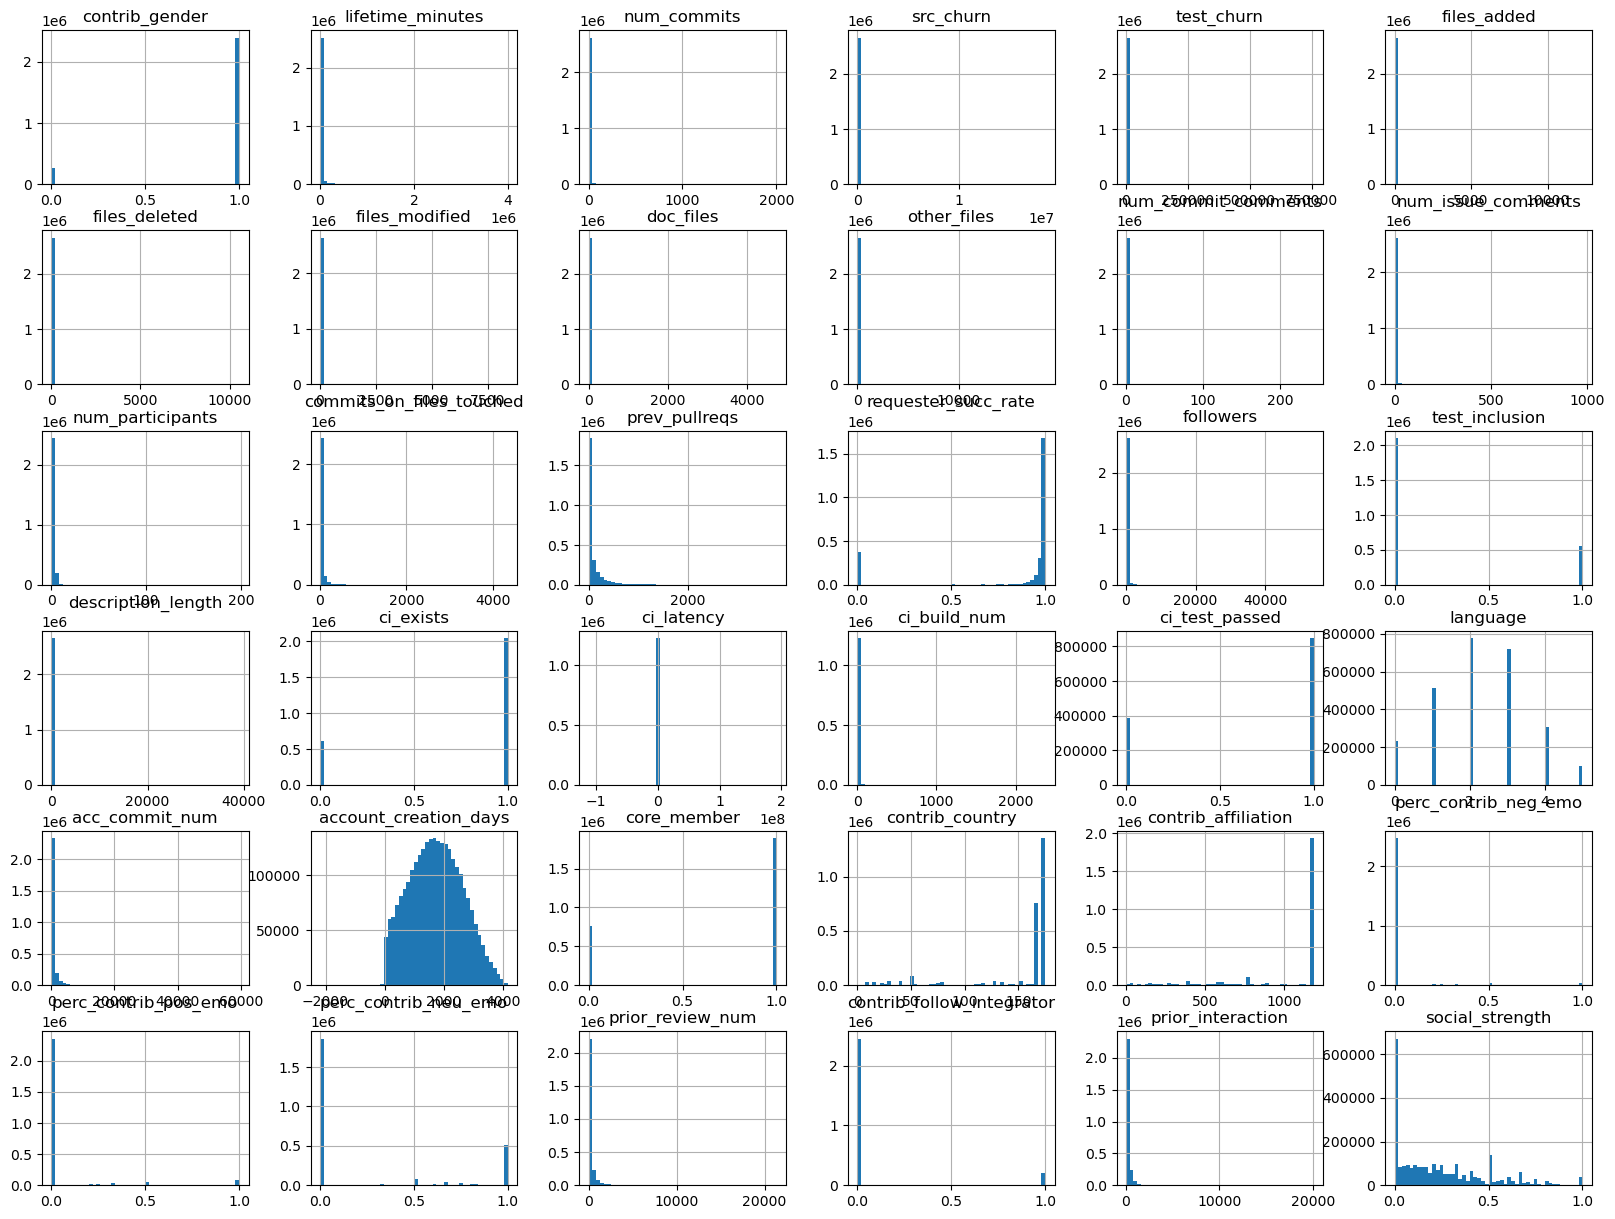

In [44]:
data_contributer.hist(bins=50, figsize=(20,15))
plt.show()


### Dealing with the missing data and features

In [28]:
#dropping the rows where column ci_exists has a null value
data_contributer = data_contributer.dropna(subset=['ci_exists'], axis=0)

#filling the null values of ci_latency, ci build_num and ci_test_passed by median if ci_exists is 1 and fill by the value 0.0 if ci_exists is 0
data_contributer["ci_latency"] = data_contributer.groupby("ci_exists")["ci_latency"].transform(lambda row: row.fillna(row.median()) if row.name == 1.0 else row.fillna(0.0))
data_contributer["ci_build_num"] = data_contributer.groupby("ci_exists")["ci_build_num"].transform(lambda row: row.fillna(row.median()) if row.name == 1.0 else row.fillna(0.0))
data_contributer["ci_test_passed"] = data_contributer.groupby("ci_exists")["ci_test_passed"].transform(lambda row: row.fillna(row.median()) if row.name == 1.0 else row.fillna(0.0))

#filling the null values of contrib_open, contrib_cons, contrib_extra, contrib_agree, contrib_neur by mean
# data_contributer["contrib_open"] = data_contributer["contrib_open"].fillna(data_contributer["contrib_open"].mean())
# data_contributer["contrib_cons"] = data_contributer["contrib_cons"].fillna(data_contributer["contrib_cons"].mean())
# data_contributer["contrib_extra"] = data_contributer["contrib_extra"].fillna(data_contributer["contrib_extra"].mean())
# data_contributer["contrib_agree"] = data_contributer["contrib_agree"].fillna(data_contributer["contrib_agree"].mean())
# data_contributer["contrib_neur"] = data_contributer["contrib_neur"].fillna(data_contributer["contrib_neur"].mean())

#filling the null values of perc_contrib_neg_emo, perc_contrib_pos_emo, perc_contrib_neu_emo by 0.0
data_contributer["perc_contrib_neg_emo"] = data_contributer["perc_contrib_neg_emo"].fillna(0.0)
data_contributer["perc_contrib_pos_emo"] = data_contributer["perc_contrib_pos_emo"].fillna(0.0)
data_contributer["perc_contrib_neu_emo"] = data_contributer["perc_contrib_neu_emo"].fillna(0.0)

#filling the null values of social_strength by 0.0
data_contributer["social_strength"] = data_contributer["social_strength"].fillna(0.0)




This is distribution of features after dealing with the missing values

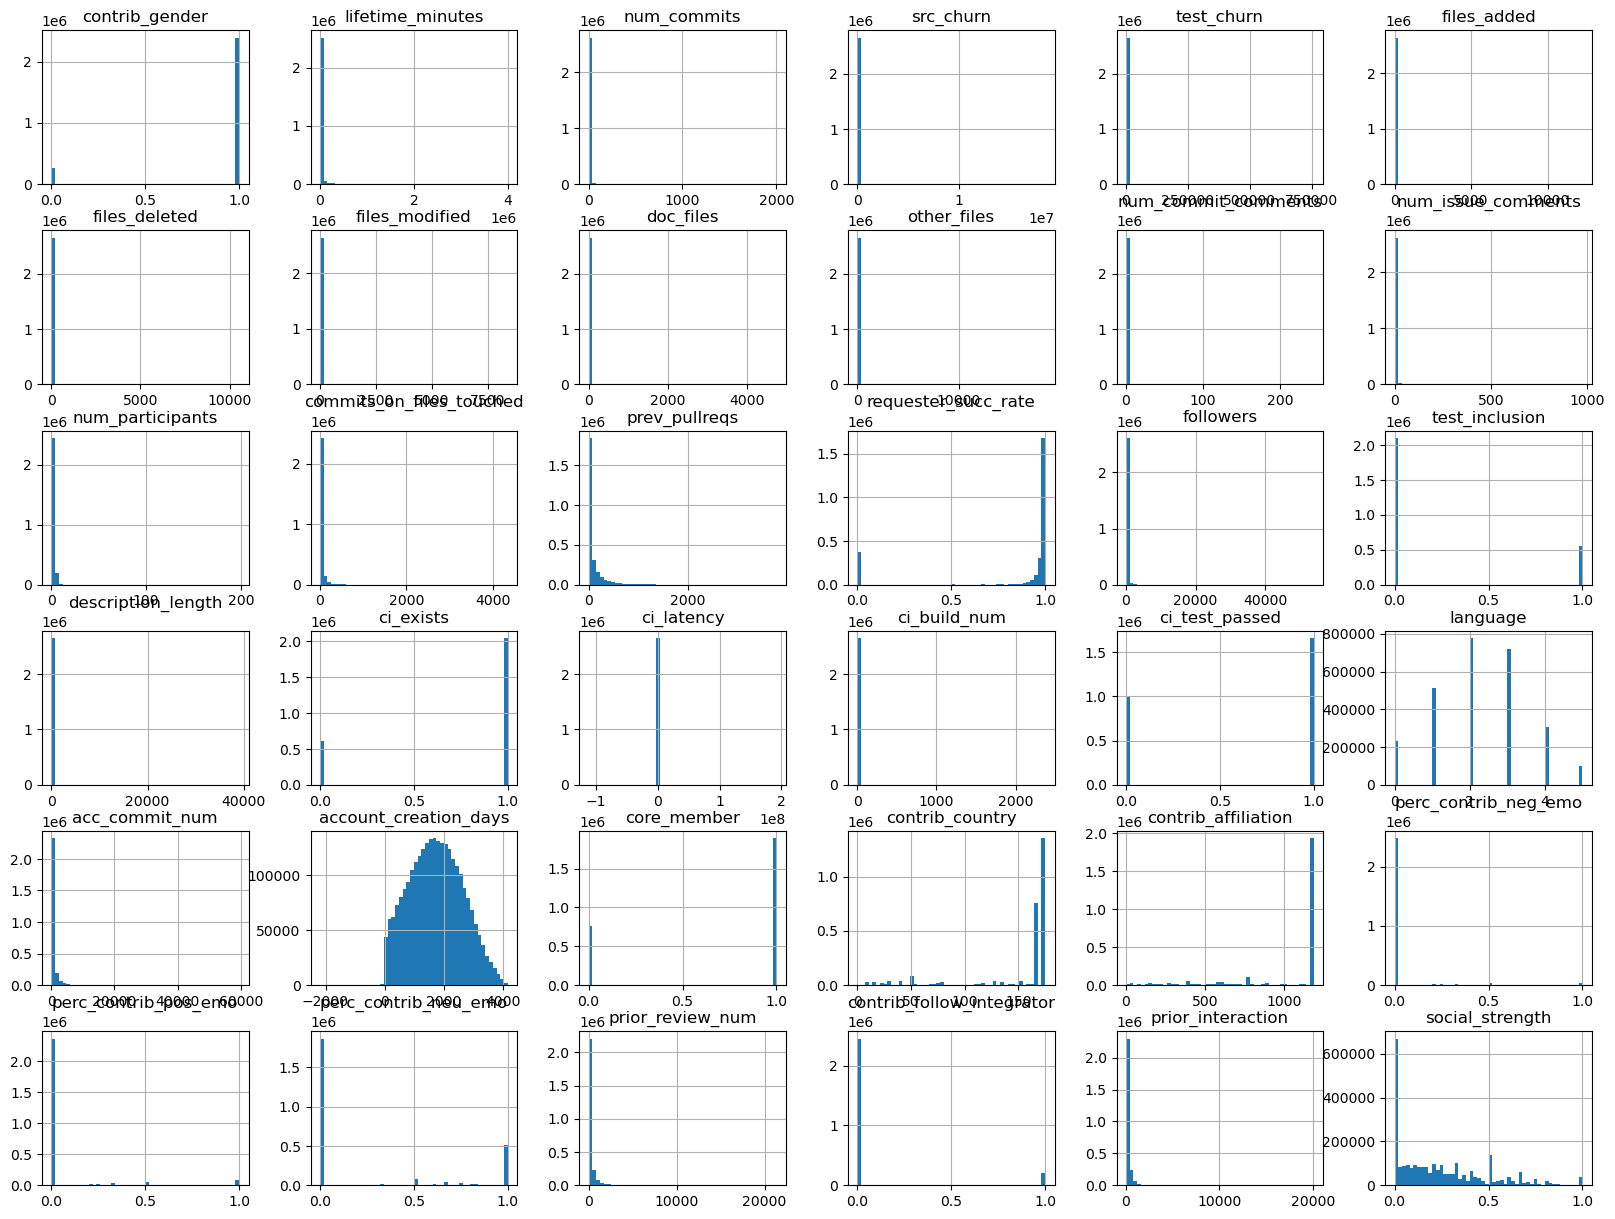

In [46]:
data_contributer.hist(bins=50, figsize=(20,15))
plt.show()

## Model-Dependent Feature Importance

first i am going to split the dataset to train and test, Here. I am going to use stratify to keep the ratio of the unbalanced dataset that we have here.

In [29]:
X = data_contributer.drop("contrib_gender", axis=1)
y = data_contributer["contrib_gender"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y ,random_state=42)

In [30]:
print(f"Dimensions of feature values of the training set: {X_train.shape}")
print(f"Dimensions of feature values of the test set: {X_test.shape}")
print(f"Dimensions of target value of the training set: {y_train.shape}")
print(f"Dimensions of target value of the test set: {y_test.shape}")

Dimensions of feature values of the training set: (2121070, 35)
Dimensions of feature values of the test set: (530268, 35)
Dimensions of target value of the training set: (2121070,)
Dimensions of target value of the test set: (530268,)


### Support Vector Machine

In [31]:
clf = LinearSVC(random_state=42, tol=1e-5)
clf.fit(X_train, y_train)

/Users/amirrshams/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(random_state=42, tol=1e-05)

In [32]:
coef = clf.coef_

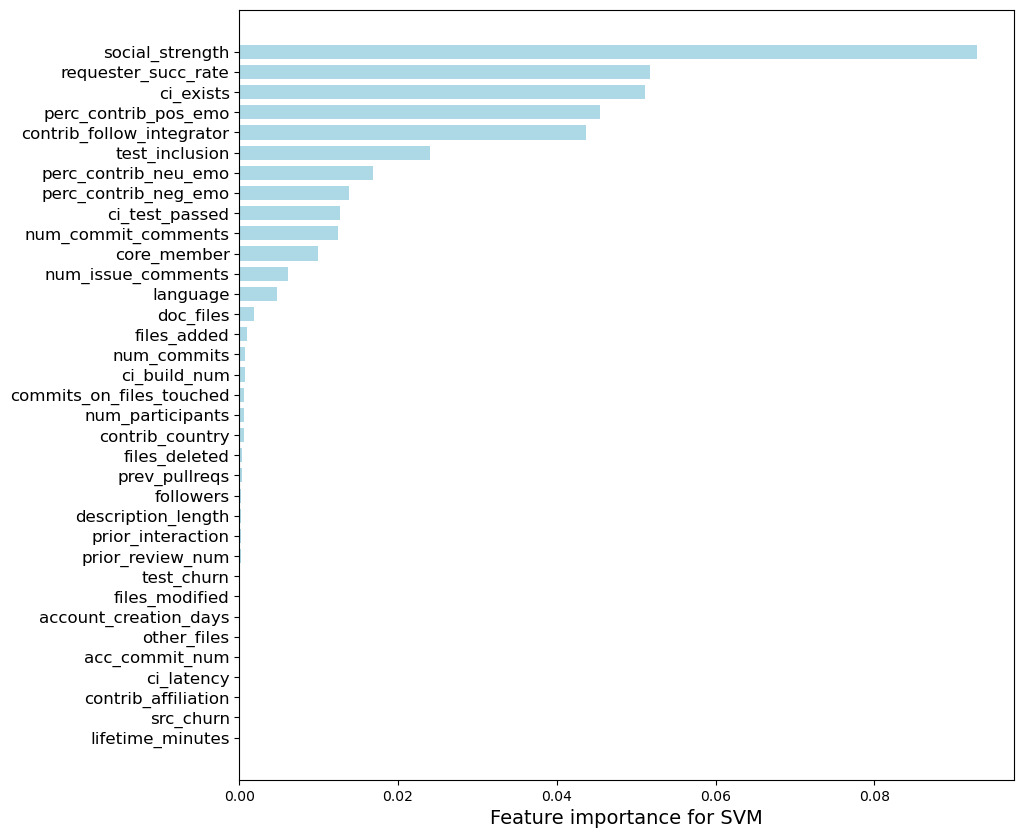

Accuracy of the model: 0.8956112758077048
Precision of the model: 0.8194054059737257
Recall of the model: 0.8956112758077048
F1 score of the model: 0.8528351740717001


In [33]:
# Getting the absolute values of the coefficients
imp_svc = np.abs(coef)
# Summing the coefficients across classes
imp_svc = np.sum(imp_svc, axis=0)
# Sorting the coefficients by importance
imp_svc, feature_names_svc = zip(*sorted(zip(imp_svc, X.columns), reverse=False))
# Plotting the bar chart
plt.figure(figsize=(10, 10)) 
plt.barh(range(len(feature_names_svc)), imp_svc, align='center', color='lightblue', ecolor='black', height=0.7)
plt.yticks(range(len(feature_names_svc)), feature_names_svc, fontsize=12)
plt.xlabel('Feature importance for SVM', fontsize=14)
plt.show()

#the accuracy of the model
print(f"Accuracy of the model: {clf.score(X_test, y_test)}")
#the precision of the model
print(f"Precision of the model: {precision_score(y_test, clf.predict(X_test), average='weighted')}")
#the recall of the model
print(f"Recall of the model: {recall_score(y_test, clf.predict(X_test), average='weighted')}")
#the f1 score of the model
print(f"F1 score of the model: {f1_score(y_test, clf.predict(X_test), average='weighted')}")


Using LinearSVC as it was faster than SVC

SVC is known to be very slow and impractical for large datasets, because it has a time complexity of O(n_samples^2 * n_features) or worse12
 in general, LinearSVC is much faster and more scalable than SVC, because it has a time complexity of O(n_samples * n_features) 

For example, according to this answer2, training a linear SVC on a dataset of 100k samples and 5 features took 3 seconds. Extrapolating from this, training a linear SVC on a dataset of 2.4 million samples and 41 features could take around 120 seconds, which is much more realistic.

However, this is only an approximation and it could vary depending on the data and the model. You should try to run LinearSVC on a small subset of your data first and measure the runtime, then scale it up to the full dataset. You should also tune the parameters of LinearSVC to optimize its performance and accuracy3.

In [45]:
#write the coef of the model in a dataframe
coef_df = pd.DataFrame({'feature': feature_names_svc, 'importance': np.dot(imp_svc, 100)})
coef_df

,feature,importance
0,lifetime_minutes,0.000490
1,src_churn,0.001650
2,followers,0.001903
3,account_creation_days,0.002961
4,test_churn,0.003170
5,prior_review_num,0.003365
6,ci_latency,0.007489
7,files_added,0.009371
8,acc_commit_num,0.010141
9,contrib_country,0.016294


## Logistic Regression

In [46]:
#Creating an instance of the class
log_reg = LogisticRegression(random_state=42, max_iter=1000)
#Fitting the model to the training data
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

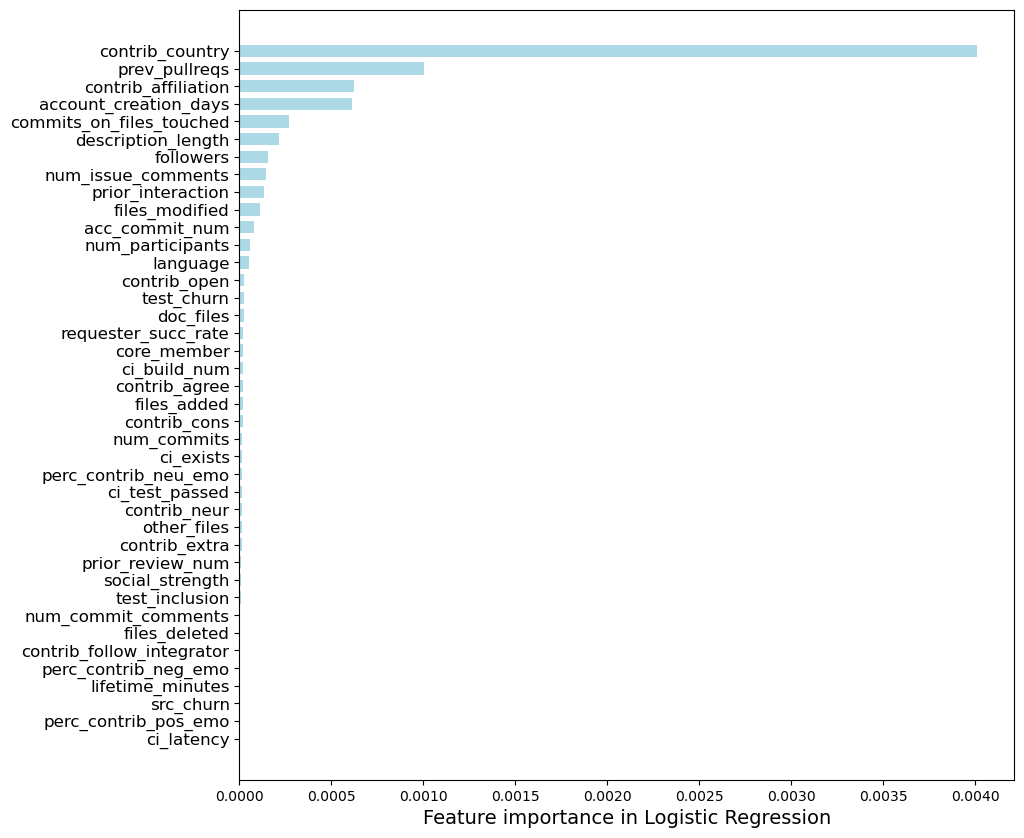

Accuracy of the model: 0.9023757797943681
Precision of the model: 0.9119133727786963
Recall of the model: 0.9023757797943681
F1 score of the model: 0.8568042334435985


In [47]:
#Getting the coefficients of the features
coef_lr = log_reg.coef_
#Getting the absolute values of the coefficients
imp_lr = np.abs(coef_lr)
#Summing the coefficients across classes
imp_lr = np.sum(imp_lr, axis=0)
#Sorting the coefficients by importance
imp_lr, feature_names_lr = zip(*sorted(zip(imp_lr, X.columns), reverse=False))
#Plotting the bar chart
plt.figure(figsize=(10, 10))
plt.barh(range(len(feature_names_lr)), imp_lr, align='center', color='lightblue', ecolor='black', height=0.7)
plt.yticks(range(len(feature_names_lr)), feature_names_lr, fontsize=12)
plt.xlabel('Feature importance in Logistic Regression', fontsize=14)
plt.show()

#the accuracy of the model
print(f"Accuracy of the model: {log_reg.score(X_test, y_test)}")
#the precision of the model
print(f"Precision of the model: {precision_score(y_test, log_reg.predict(X_test), average='weighted')}")
#the recall of the model
print(f"Recall of the model: {recall_score(y_test, log_reg.predict(X_test), average='weighted')}")
#the f1 score of the model
print(f"F1 score of the model: {f1_score(y_test, log_reg.predict(X_test), average='weighted')}")




In [ ]:
coef_lr_df = pd.DataFrame({'feature': feature_names_lr, 'importance': np.dot(imp_lr, 100)})
coef_lr_df

,feature,importance
0,contrib_country,4.060052e-01
1,prev_pullreqs,1.157235e-01
2,account_creation_days,6.209380e-02
3,contrib_affiliation,6.133197e-02
4,commits_on_files_touched,2.729022e-02
5,description_length,2.397739e-02
6,followers,2.348953e-02
7,prior_interaction,1.810326e-02
8,num_issue_comments,1.472152e-02
9,files_modified,1.082449e-02


## Desicion Tree Classifier

In [48]:
# Creating an instance of the classifier
dt = DecisionTreeClassifier(random_state=42)

# Fitting the classifier to the training data
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

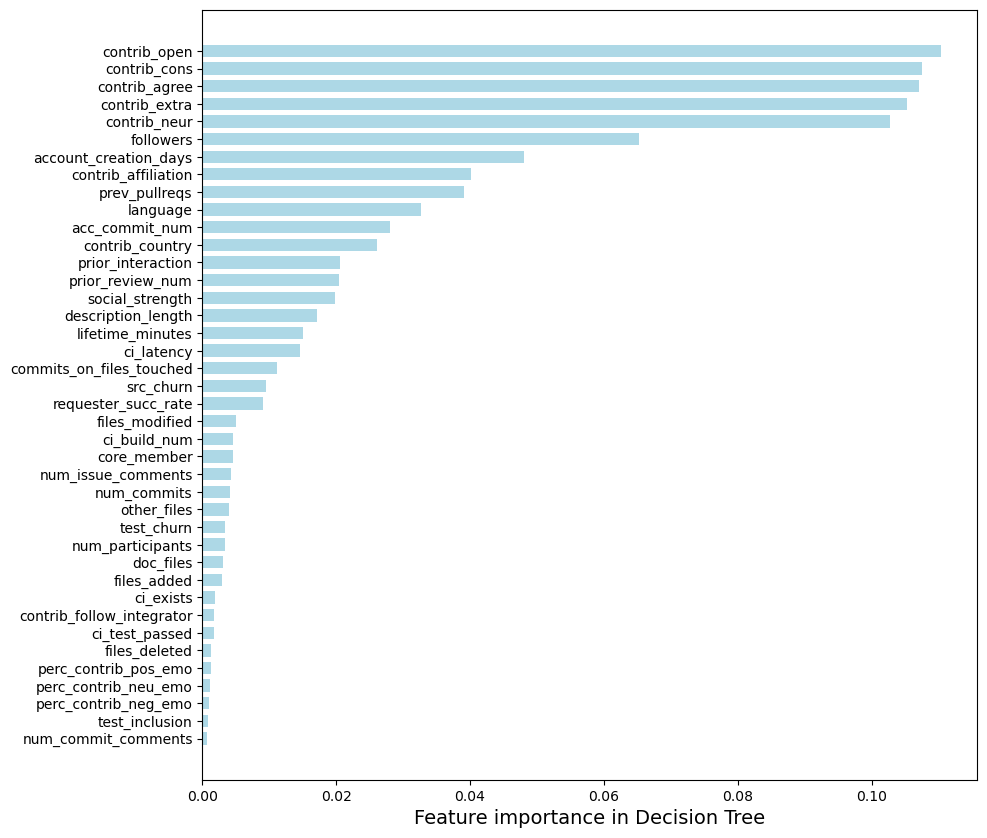

Accuracy of the model: 0.9691514479470759
Precision of the model: 0.9695585855873387
Recall of the model: 0.9691514479470759
F1 score of the model: 0.9693376790294508


In [49]:
imp_dt = dt.feature_importances_

# Sorting the feature importance by descending order
imp_dt, feature_names_dt = zip(*sorted(zip(imp_dt, X.columns), reverse=False))

# Plotting the bar chart
plt.figure(figsize=(10, 10))
plt.barh(range(len(feature_names_dt)), imp_dt, align='center', color='lightblue', ecolor='black', height=0.7)
plt.yticks(range(len(feature_names_dt)), feature_names_dt, fontsize=10)
plt.xlabel('Feature importance in Decision Tree', fontsize=14)
plt.show()

# The accuracy of the model
print(f"Accuracy of the model: {dt.score(X_test, y_test)}")
# The precision of the model
print(f"Precision of the model: {precision_score(y_test, dt.predict(X_test), average='weighted')}")
# The recall of the model
print(f"Recall of the model: {recall_score(y_test, dt.predict(X_test), average='weighted')}")
# The f1 score of the model
print(f"F1 score of the model: {f1_score(y_test, dt.predict(X_test), average='weighted')}")

In [50]:
coef_dt = pd.DataFrame({'feature': feature_names_dt, 'importance': np.dot(imp_dt, 100)})
coef_dt

,feature,importance
0,num_commit_comments,0.061845
1,test_inclusion,0.077212
2,perc_contrib_neg_emo,0.097910
3,perc_contrib_neu_emo,0.106081
4,perc_contrib_pos_emo,0.122697
5,files_deleted,0.134585
6,ci_test_passed,0.178377
7,contrib_follow_integrator,0.179223
8,ci_exists,0.193840
9,files_added,0.284430


## Random Forest Classifier

In [47]:
# Creating SMOTE object
smote = SMOTE()
# Fitting SMOTE to training data
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)


In [51]:
# Creating an instance of the classifier
rf = RandomForestClassifier(random_state=42)

# Fitting the classifier to the training data
rf.fit(X_train_resampled, y_train_resampled)


RandomForestClassifier(random_state=42)

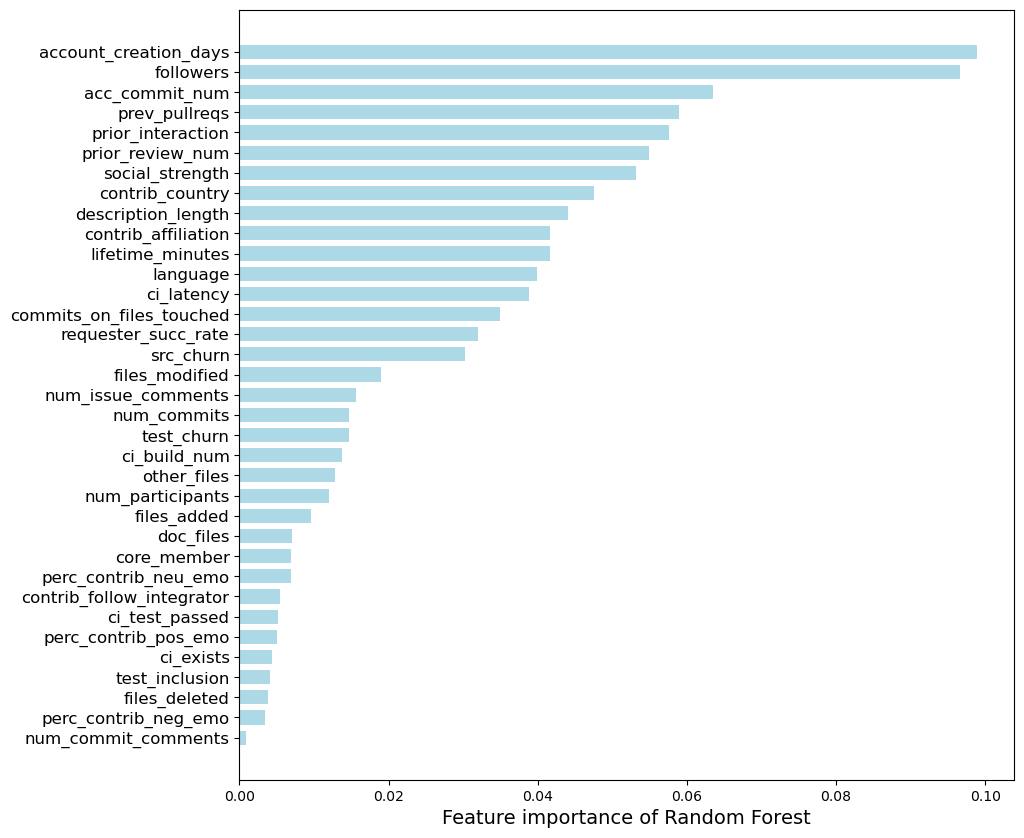

Accuracy of the model: 0.954032677815746
Precision of the model: 0.9936050023093047
Recall of the model: 0.5361565890878417
F1 score of the model: 0.6964848273543438


In [52]:
imp_rf = rf.feature_importances_
#Sorting the coefficients by importance
imp_rf, feature_names_rf = zip(*sorted(zip(imp_rf, X.columns), reverse=False))
#Plotting the bar chart
plt.figure(figsize=(10, 10))
plt.barh(range(len(feature_names_rf)), imp_rf, align='center', color='lightblue', ecolor='black', height=0.7)
plt.yticks(range(len(feature_names_rf)), feature_names_rf, fontsize=12)
plt.xlabel('Feature importance of Random Forest', fontsize=14)
plt.show()

#the accuracy of the model
print(f"Accuracy of the model: {rf.score(X_test, y_test)}")
#the precision of the model
print(f"Precision of the model: {precision_score(y_test, rf.predict(X_test), average='binary')}")
#the recall of the model
print(f"Recall of the model: {recall_score(y_test, rf.predict(X_test), average='binary')}")
#the f1 score of the model
print(f"F1 score of the model: {f1_score(y_test, rf.predict(X_test), average='binary')}")




In [53]:
print(confusion_matrix(y_test, rf.predict(X_test)))
print(classification_report(y_test, rf.predict(X_test)))

[[477926    180]
 [ 24195  27967]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.98    478106
           1       0.99      0.54      0.70     52162

    accuracy                           0.95    530268
   macro avg       0.97      0.77      0.84    530268
weighted avg       0.96      0.95      0.95    530268



In [41]:
fi_rf = pd.DataFrame({'feature': feature_names_rf, 'importance': np.dot(imp_rf, 100)})
fi_rf

,feature,importance
0,num_commit_comments,0.144019
1,perc_contrib_neg_emo,0.393222
2,ci_exists,0.433497
3,test_inclusion,0.464203
4,contrib_follow_integrator,0.518782
5,files_deleted,0.529008
6,ci_test_passed,0.587960
7,perc_contrib_pos_emo,0.605545
8,doc_files,0.725220
9,perc_contrib_neu_emo,0.740253


## Dense Neural Netwrok using Pytorch

In [5]:
class GenderClassifier(nn.Module):
  def __init__(self):
    super(GenderClassifier, self).__init__()
    self.fc1 = nn.Linear(41,16)
    self.fc2 = nn.Linear(16, 32)
    self.fc3 = nn.Linear(32, 16)
    self.fc4 = nn.Linear(16, 1)
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()
  def forward(self, x):
    x = self.fc1(x) 
    x = self.relu(x)
    x = self.fc2(x) 
    x = self.relu(x)
    x = self.fc3(x) 
    x = self.relu(x)
    x = self.fc4(x) 
    x = self.sigmoid(x)
    return x    

In [6]:
# Define your training loop
def train(model, criterion, optimizer, dataloader):
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs.float())
        loss = criterion(outputs, labels.float().unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(dataloader.dataset)


In [7]:
def validate(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs.float())
            loss = criterion(outputs, labels.float().unsqueeze(1))
            running_loss += loss.item() * inputs.size(0)
    return running_loss / len(dataloader.dataset)

In [50]:
#oversampling the data
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

In [10]:
# Creating SMOTE object
smote = SMOTE()
# Fitting SMOTE to training data
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)


In [11]:
# Converting the data to tensors
X_train_nn = torch.from_numpy(X_train_balanced.to_numpy()).float()
y_train_nn = torch.from_numpy(y_train_balanced.to_numpy()).long()
X_test_nn = torch.from_numpy(X_test.to_numpy()).float()
y_test_nn = torch.from_numpy(y_test.to_numpy()).long()

# Check if cuda is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

X_train_nn = X_train_nn.to(device)
y_train_nn = y_train_nn.to(device)
X_test_nn = X_test_nn.to(device)
y_test_nn = y_test_nn.to(device)

train_loader = DataLoader(TensorDataset(X_train_nn, y_train_nn), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_nn, y_test_nn), batch_size=64, shuffle=False)

model = GenderClassifier()
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [12]:
for epoch in range(10):
    train_loss = train(model, criterion, optimizer, train_loader)
    test_loss = validate(model, criterion, test_loader)
    print(f"Epoch {epoch+1}: Train loss: {train_loss:.4f} | Val loss: {test_loss:.4f}")

Epoch 1: Train loss: 0.7095 | Val loss: 0.6803
Epoch 2: Train loss: 0.6154 | Val loss: 0.5666
Epoch 3: Train loss: 0.6027 | Val loss: 0.6078
Epoch 4: Train loss: 0.6001 | Val loss: 0.5561
Epoch 5: Train loss: 0.5927 | Val loss: 0.7327
Epoch 6: Train loss: 0.5866 | Val loss: 0.5578
Epoch 7: Train loss: 0.5838 | Val loss: 0.6546
Epoch 8: Train loss: 0.5814 | Val loss: 0.6048
Epoch 9: Train loss: 0.5800 | Val loss: 0.5420
Epoch 10: Train loss: 0.5837 | Val loss: 0.5987


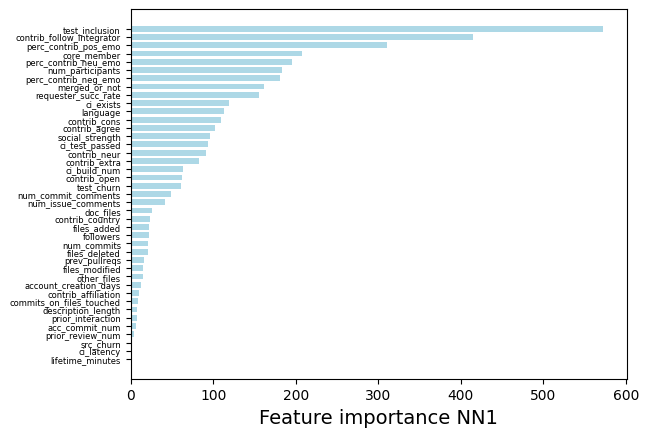

In [15]:
# Getting the feature importance of the model
imp_nn = model.fc1.weight.data.cpu().numpy() # Getting the weights of the first layer
imp_nn = np.abs(imp_nn) # Getting the absolute values of the weights
imp_nn = np.sum(imp_nn, axis=0) # Summing the weights across output nodes
imp_nn, feature_names_nn = zip(*sorted(zip(imp_nn, X.columns))) # Sorting the weights by importance

# Plotting the bar chart
plt.barh(range(len(feature_names_nn)), imp_nn, align='center', color='lightblue', ecolor='black', height=0.7)
plt.yticks(range(len(feature_names_nn)), feature_names_nn, fontsize=6)
plt.xlabel('Feature importance NN1', fontsize=14)
plt.show()

In [14]:
# Forward pass on GPU
y_pred = model(X_test_nn) 
# Getting the class labels
y_pred = (y_pred > 0.5).float() 
# Moving to CPU and convert to numpy array
y_pred = y_pred.cpu().numpy() 
# Getting the true labels
y_true = y_test_nn 
# Moving to CPU and convert to numpy array
y_true = y_true.cpu().numpy() 

# Calculating the metrics
acc = accuracy_score(y_true, y_pred) # Accuracy
prec = precision_score(y_true, y_pred, average='weighted') # Precision
rec = recall_score(y_true, y_pred, average='weighted') # Recall
f1 = f1_score(y_true, y_pred, average='weighted') # F1 score

print(f"Accuracy of the model: {acc}")
print(f"Precision of the model: {prec}")
print(f"Recall of the model: {rec}")
print(f"F1 score of the model: {f1}")

Accuracy of the model: 0.6744928979308576
Precision of the model: 0.8505429080417789
Recall of the model: 0.6744928979308576
F1 score of the model: 0.7382330134441607


In [21]:
# Converting the data to tensors
X_train_nn = torch.from_numpy(X_train_resampled.to_numpy()).float()
y_train_nn = torch.from_numpy(y_train_resampled.to_numpy()).long()
X_test_nn = torch.from_numpy(X_test.to_numpy()).float()
y_test_nn = torch.from_numpy(y_test.to_numpy()).long()

# Check if cuda is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

X_train_nn = X_train_nn.to(device)
y_train_nn = y_train_nn.to(device)
X_test_nn = X_test_nn.to(device)
y_test_nn = y_test_nn.to(device)

train_loader = DataLoader(TensorDataset(X_train_nn, y_train_nn), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_nn, y_test_nn), batch_size=64, shuffle=False)

model = GenderClassifier()
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [22]:
for epoch in range(10):
    train_loss = train(model, criterion, optimizer, train_loader)
    test_loss = validate(model, criterion, test_loader)
    print(f"Epoch {epoch+1}: Train loss: {train_loss:.4f} | Val loss: {test_loss:.4f}")

Epoch 1: Train loss: 0.7468 | Val loss: 0.6324
Epoch 2: Train loss: 0.6407 | Val loss: 0.6624
Epoch 3: Train loss: 0.6376 | Val loss: 0.6291
Epoch 4: Train loss: 0.6335 | Val loss: 0.5986
Epoch 5: Train loss: 0.6311 | Val loss: 0.6672
Epoch 6: Train loss: 0.6290 | Val loss: 0.6397
Epoch 7: Train loss: 0.6277 | Val loss: 0.5972
Epoch 8: Train loss: 0.6269 | Val loss: 0.6289
Epoch 9: Train loss: 0.6260 | Val loss: 0.6156
Epoch 10: Train loss: 0.6262 | Val loss: 0.6449


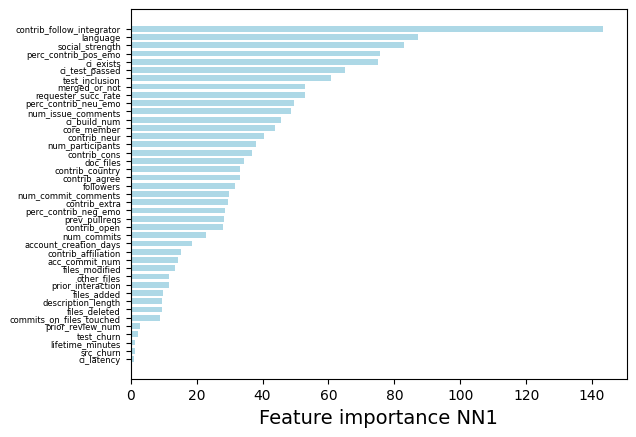

In [23]:
# Getting the feature importance of the model
imp_nn = model.fc1.weight.data.cpu().numpy() # Getting the weights of the first layer
imp_nn = np.abs(imp_nn) # Getting the absolute values of the weights
imp_nn = np.sum(imp_nn, axis=0) # Summing the weights across output nodes
imp_nn, feature_names_nn = zip(*sorted(zip(imp_nn, X.columns))) # Sorting the weights by importance

# Plotting the bar chart
plt.barh(range(len(feature_names_nn)), imp_nn, align='center', color='lightblue', ecolor='black', height=0.7)
plt.yticks(range(len(feature_names_nn)), feature_names_nn, fontsize=6)
plt.xlabel('Feature importance NN1', fontsize=14)
plt.show()

In [24]:
# Forward pass on GPU
y_pred = model(X_test_nn) 
# Getting the class labels
y_pred = (y_pred > 0.5).float() 
# Moving to CPU and convert to numpy array
y_pred = y_pred.cpu().numpy() 
# Getting the true labels
y_true = y_test_nn 
# Moving to CPU and convert to numpy array
y_true = y_true.cpu().numpy() 

# Calculating the metrics
acc = accuracy_score(y_true, y_pred) # Accuracy
prec = precision_score(y_true, y_pred, average='weighted') # Precision
rec = recall_score(y_true, y_pred, average='weighted') # Recall
f1 = f1_score(y_true, y_pred, average='weighted') # F1 score

print(f"Accuracy of the model: {acc}")
print(f"Precision of the model: {prec}")
print(f"Recall of the model: {rec}")
print(f"F1 score of the model: {f1}")

Accuracy of the model: 0.7089415163653097
Precision of the model: 0.8553627265834053
Recall of the model: 0.7089415163653097
F1 score of the model: 0.7634933481430832


In [8]:
# Converting the data to tensors
X_train_nn = torch.from_numpy(X_train.to_numpy()).float()
y_train_nn = torch.from_numpy(y_train.to_numpy()).long()
X_test_nn = torch.from_numpy(X_test.to_numpy()).float()
y_test_nn = torch.from_numpy(y_test.to_numpy()).long()

# Check if cuda is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

X_train_nn = X_train_nn.to(device)
y_train_nn = y_train_nn.to(device)
X_test_nn = X_test_nn.to(device)
y_test_nn = y_test_nn.to(device)

train_loader = DataLoader(TensorDataset(X_train_nn, y_train_nn), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_nn, y_test_nn), batch_size=64, shuffle=False)

model = GenderClassifier()
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [9]:
for epoch in range(10):
    train_loss = train(model, criterion, optimizer, train_loader)
    test_loss = validate(model, criterion, test_loader)
    print(f"Epoch {epoch+1}: Train loss: {train_loss:.4f} | Val loss: {test_loss:.4f}")

Epoch 1: Train loss: 0.3720 | Val loss: 0.3144
Epoch 2: Train loss: 0.3061 | Val loss: 0.3046
Epoch 3: Train loss: 0.3149 | Val loss: 0.3017
Epoch 4: Train loss: 0.3065 | Val loss: 0.3435
Epoch 5: Train loss: 0.3063 | Val loss: 0.3034
Epoch 6: Train loss: 0.3063 | Val loss: 0.3000
Epoch 7: Train loss: 0.3046 | Val loss: 0.3003
Epoch 8: Train loss: 0.3022 | Val loss: 0.2994
Epoch 9: Train loss: 0.3053 | Val loss: 0.3004
Epoch 10: Train loss: 0.3024 | Val loss: 0.2988


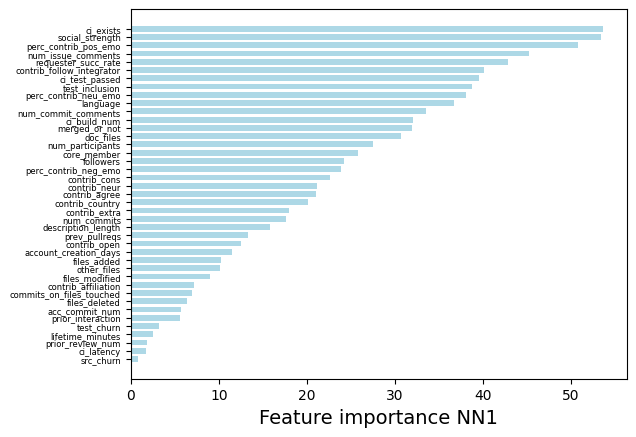

In [10]:
# Getting the feature importance of the model
imp_nn = model.fc1.weight.data.cpu().numpy() # Getting the weights of the first layer
imp_nn = np.abs(imp_nn) # Getting the absolute values of the weights
imp_nn = np.sum(imp_nn, axis=0) # Summing the weights across output nodes
imp_nn, feature_names_nn = zip(*sorted(zip(imp_nn, X.columns))) # Sorting the weights by importance

# Plotting the bar chart
plt.barh(range(len(feature_names_nn)), imp_nn, align='center', color='lightblue', ecolor='black', height=0.7)
plt.yticks(range(len(feature_names_nn)), feature_names_nn, fontsize=6)
plt.xlabel('Feature importance NN1', fontsize=14)
plt.show()

# Forward pass on GPU
y_pred = model(X_test_nn) 
# Getting the class labels
y_pred = (y_pred > 0.5).float() 
# Moving to CPU and convert to numpy array
y_pred = y_pred.cpu().numpy() 
# Getting the true labels
y_true = y_test_nn 
# Moving to CPU and convert to numpy array
y_true = y_true.cpu().numpy() 

# Calculating the metrics
acc = accuracy_score(y_true, y_pred) # Accuracy
prec = precision_score(y_true, y_pred, average='weighted') # Precision
rec = recall_score(y_true, y_pred, average='weighted') # Recall
f1 = f1_score(y_true, y_pred, average='weighted') # F1 score

print(f"Accuracy of the model: {acc}")
print(f"Precision of the model: {prec}")
print(f"Recall of the model: {rec}")
print(f"F1 score of the model: {f1}")